In [1]:
import os
import shutil
import logging
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Define directories
source_dir = "/content/drive/MyDrive/Colab Notebooks/thermal_images/thermal_dataset/thermal images UL"
output_dir = "/content/drive/MyDrive/Colab Notebooks/thermal_images/thermal_dataset/processed_data_Unet"

# Define classes
classes = ['Blast', 'BLB', 'healthy', 'hispa', 'leaf folder', 'leaf spot']

Mounted at /content/drive


In [3]:
def prepare_data(source_dir, output_dir, classes, test_size=0.2, val_size=0.2):
    """Prepare and split the dataset with error handling and logging."""
    splits = ['train', 'validation', 'test']

    # Create directories for splits
    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    # Track dataset statistics
    class_counts = {}

    for cls in classes:
        class_dir = os.path.join(source_dir, cls)
        if not os.path.exists(class_dir):
            logger.error(f"Class directory not found: {class_dir}")
            continue

        images = [img for img in os.listdir(class_dir)
                 if img.lower().endswith(('jpg', 'jpeg', 'png'))]

        if not images:
            logger.warning(f"No images found in class: {cls}")
            continue

        class_counts[cls] = len(images)
        image_paths = [os.path.join(class_dir, img) for img in images]

        # Split data
        train_val_images, test_images = train_test_split(
            image_paths, test_size=test_size, random_state=42, shuffle=True)
        train_images, val_images = train_test_split(
            train_val_images, test_size=val_size, random_state=42, shuffle=True)

        # Copy images with error handling
        for img_list, split in [(train_images, 'train'),
                              (val_images, 'validation'),
                              (test_images, 'test')]:
            for img_path in img_list:
                try:
                    shutil.copy(img_path, os.path.join(output_dir, split, cls))
                except Exception as e:
                    logger.error(f"Error copying {img_path}: {str(e)}")

    logger.info("Class distribution:")
    for cls, count in class_counts.items():
        logger.info(f"{cls}: {count} images")

    return class_counts


In [4]:
def create_data_generators(output_dir, img_size=(224, 224), batch_size=32):
    """Create data generators with augmentation."""
    datagen_train = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    datagen_val_test = ImageDataGenerator(rescale=1./255)

    train_generator = datagen_train.flow_from_directory(
        os.path.join(output_dir, 'train'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = datagen_val_test.flow_from_directory(
        os.path.join(output_dir, 'validation'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = datagen_val_test.flow_from_directory(
        os.path.join(output_dir, 'test'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

In [5]:
def build_efficient_model(input_shape=(224, 224, 3), num_classes=6):
    """Build an EfficientNetB0-based model with transfer learning."""
    base_model = applications.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze the base model
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_acc')]
    )

    return model

In [6]:
def train_model(model, train_gen, val_gen, epochs=50, class_weights=None):
    """Train the model with callbacks and optional class weights."""
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            'best_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    return history

In [7]:
def calculate_class_weights(class_counts):
    """Calculate class weights for imbalanced dataset."""
    total = sum(class_counts.values())
    max_samples = max(class_counts.values())
    class_weights = {i: max_samples / count for i, count in enumerate(class_counts.values())}
    return class_weights

def evaluate_model(model, test_generator):
    """Evaluate the model and print detailed metrics."""
    results = model.evaluate(test_generator, verbose=1)
    print("\nTest Results:")
    for metric_name, value in zip(model.metrics_names, results):
        print(f"{metric_name}: {value:.4f}")

def fine_tune_model(model, train_gen, val_gen, epochs=30):
    """Fine-tune the model by unfreezing some layers."""
    # Unfreeze the top layers of the base model
    base_model = model.layers[0]
    base_model.trainable = True

    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Recompile with a lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_acc')]
    )

    # Train with the same callbacks
    history = train_model(model, train_gen, val_gen, epochs=epochs)
    return history

In [8]:
# Main execution
if __name__ == "__main__":
    # Prepare data and get class distribution
    class_counts = prepare_data(source_dir, output_dir, classes)

    # Calculate class weights for imbalanced dataset
    class_weights = calculate_class_weights(class_counts)

    # Create data generators
    train_gen, val_gen, test_gen = create_data_generators(output_dir)

    # Build and train initial model
    model = build_efficient_model()
    logger.info("Training initial model...")
    history = train_model(model, train_gen, val_gen, epochs=30, class_weights=class_weights)

    # Evaluate initial model
    logger.info("Evaluating initial model...")
    evaluate_model(model, test_gen)

    # Fine-tune the model
    logger.info("Fine-tuning the model...")
    fine_tune_history = fine_tune_model(model, train_gen, val_gen)

    # Final evaluation
    logger.info("Final model evaluation...")
    evaluate_model(model, test_gen)

    # Save the final model
    model.save('final_thermal_classification_model.h5')
    logger.info("Model saved successfully!")

Found 619 images belonging to 6 classes.
Found 244 images belonging to 6 classes.
Found 269 images belonging to 6 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1776 - loss: 7.7260 - top2_acc: 0.3342
Epoch 1: val_accuracy improved from -inf to 0.10246, saving model to best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step - accuracy: 0.1774 - loss: 7.7111 - top2_acc: 0.3337 - val_accuracy: 0.1025 - val_loss: 1.8655 - val_top2_acc: 0.1598 - learning_rate: 0.0010
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1861 - loss: 6.7372 - top2_acc: 0.3732
Epoch 2: val_accuracy improved from 0.10246 to 0.34836, saving model to best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.1861 - loss: 6.7351 - top2_acc: 0.3723 - val_accuracy: 0.3484 - val_loss: 1.7611 - val_top2_acc: 0.4508 - learning_rate: 0.0010
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1972 - loss: 7.0902 - top2_acc: 0.3349
Epoch 3: val_accuracy did not improve from 0.34836
20/20 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.1975 - loss: 7.0674 - top2_acc: 0.3364 - val_accuracy: 0.3484 - val_loss: 1.7146 - val_top2_acc: 0.4057 - learning_rate: 0.0010
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2833 - loss: 5.6039 - top2_acc: 0.4340
Epoch 4: val_accuracy did not improve from 0.34836
20/20 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.2820 - loss: 5.6149 - top2_acc: 0.4331 - val_accuracy: 0.3484 - val_loss: 1.7205 - val_top2_acc: 0.4057 - learning_rate: 0.0010
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2244 - loss: 5.7534 - top2_acc: 0.4248
Epoch 5: val_accuracy did not improve from 0.3483

20/20 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.1538 - loss: 2.9360 - top2_acc: 0.3261 - val_accuracy: 0.3484 - val_loss: 1.7656 - val_top2_acc: 0.4508 - learning_rate: 1.0000e-05
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1949 - loss: 2.7470 - top2_acc: 0.3897
Epoch 2: val_accuracy did not improve from 0.34836
20/20 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.1949 - loss: 2.7443 - top2_acc: 0.3890 - val_accuracy: 0.3484 - val_loss: 1.7744 - val_top2_acc: 0.4508 - learning_rate: 1.0000e-05
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1918 - loss: 2.6930 - top2_acc: 0.3780
Epoch 3: val_accuracy did not improve from 0.34836
20/20 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.1916 - loss: 2.6922 - top2_acc: 0.3776 - val_accuracy: 0.3484 - val_loss: 1.7860 - val_top2_acc: 0.4508 - learning_rate: 1.0000e-05
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1901 - loss: 2.6420 - top2_acc: 0.3768
Epoch 4: val_accuracy did not improv


Test Results:
loss: 1.7686
compile_metrics: 0.3420


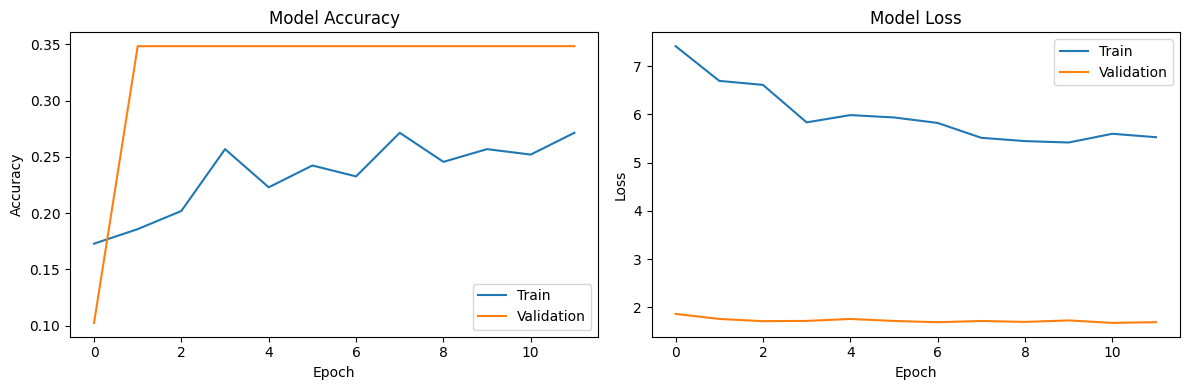

In [16]:
import matplotlib.pyplot as plt

# Make sure to import matplotlib at the top of your code
import matplotlib.pyplot as plt

# Plot the training history
def plot_training_history(history):
    # Create a figure with 2 subplots side by side
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plot
    plt.show()

# After training your model, call this function:
plot_training_history(history)